In [1]:
#  Copyright (c) 2023 DZX.
#
#  All rights reserved.
#
#  This software is protected by copyright law and international treaties. No part of this software may be reproduced, distributed, or transmitted in any form or by any means, including photocopying, recording, or other electronic or mechanical methods, without the prior written permission of the copyright owner.
#
#  For permission requests, please contact the copyright owner at the address below.
#
#  DZX
#
#  xindemicro@outlook.com
#

In [2]:
!nvidia-smi

Wed May  3 07:41:19 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P8    12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 导入库

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import os
path = "/content/drive/MyDrive/"
os.chdir(path)

Mounted at /content/drive


In [5]:
# Standard library imports
import csv
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import pickle
import tensorflow as tf
import warnings

from keras.callbacks import Callback
from keras.layers import Conv1D, Dense, Embedding, Bidirectional, Dropout, GlobalAveragePooling1D, GlobalMaxPooling1D, Input, LSTM, MultiHeadAttention
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.regularizers import l2
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from tqdm import tqdm

from tensorflow.keras.layers import Conv1D, Dense, Embedding, Flatten, MaxPooling1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Embedding, MultiHeadAttention, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences



# Jupyter-specific imports
%matplotlib inline

# Download required NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Define Porter Stemmer and Stop Words
porter_stemmer = PorterStemmer()
stop_words = list(stopwords.words("english"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [6]:
max_vocab=600000
max_len=1000

# 读入数据

In [ ]:
# nrows_to_test = 1000
# while True:
#     try:
#         email_data = pd.read_csv("cleaned_email_06_full.csv", dtype={'email_id': object}, nrows=nrows_to_test, engine='python')
#         print(f"Successfully read {nrows_to_test} rows.")
#         nrows_to_test += 1000
#     except Exception as e:
#         print(f"Error encountered when trying to read {nrows_to_test} rows.")
#         print(e)
#         break


In [7]:
csv.field_size_limit(2**25)  # 提高字段大小限制
email_data = pd.read_csv("cleaned_email_06_full.csv", dtype={'email_id': object}, engine='python')
print(email_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34998 entries, 0 to 34997
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   email_id     34998 non-null  object
 1   parts        34998 non-null  int64 
 2   attachments  34998 non-null  int64 
 3   html         34998 non-null  int64 
 4   from         34998 non-null  object
 5   to           34998 non-null  object
 6   subject      34998 non-null  object
 7   body         34998 non-null  object
 8   links        34998 non-null  int64 
 9   spam         34998 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 2.7+ MB
None


In [8]:
email_data["spam"].value_counts()

1    22767
0    12231
Name: spam, dtype: int64

In [9]:
def stem_tokenizer(text):
    words = [porter_stemmer.stem(token) for token in word_tokenize(text.lower())]
    return " ".join([w for w in words if w not in stop_words])

In [10]:
# 在处理之前，将 'from'、'to' 和 'body' 列组合为一个新列
email_data['combined'] = email_data['from'] + ' ' + email_data['to'] + ' ' + email_data['body']

## body处理

In [ ]:
messages_body = []
for text in tqdm(email_data['body']):
  messages_body.append(stem_tokenizer(str(text)))

100%|██████████| 34998/34998 [02:00<00:00, 290.07it/s]


In [ ]:
tokenizer_body = Tokenizer(num_words=max_vocab)
tokenizer_body.fit_on_texts(messages_body)
sequences_body = tokenizer_body.texts_to_sequences(messages_body)
word_index = tokenizer_body.word_index
data_body = pad_sequences(sequences_body, maxlen=max_len)

In [ ]:
# 保存 messages
with open('message_body_stem_06.pickle', 'wb') as handle:
    pickle.dump(messages_body, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 data
with open('data_body_06.pickle', 'wb') as handle:
    pickle.dump(data_body, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 tokenizer
with open('vectokenizer_body.pickle', 'wb') as handle:
    pickle.dump(tokenizer_body, handle, protocol=pickle.HIGHEST_PROTOCOL)

## messages处理

In [11]:
messages = []
for text in tqdm(email_data['combined']):
  messages.append(stem_tokenizer(str(text)))


100%|██████████| 34998/34998 [02:10<00:00, 267.33it/s]


In [12]:
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(messages)
sequences = tokenizer.texts_to_sequences(messages)
word_index = tokenizer.word_index
data = pad_sequences(sequences, maxlen=max_len)


In [ ]:
# 保存 messages
with open('message_stem_06.pickle', 'wb') as handle:
    pickle.dump(messages, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 data
with open('data_06.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 tokenizer
with open('vectokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
# 保存 messages
with open('message_stem_06_max_len=1000.pickle', 'wb') as handle:
    pickle.dump(messages, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 data
with open('data_06_max_len=1000.pickle', 'wb') as handle:
    pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
# 保存 tokenizer
with open('vectokenizer_max_len=1000.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## 读取数据

In [ ]:
# 读取 messages
with open('message_stem_06.pickle', 'rb') as handle:
    messages = pickle.load(handle)
# 读取 data
with open('data_06.pickle', 'rb') as handle:
    data = pickle.load(handle)
# 读取 tokenizer
with open('vectokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [ ]:
# # 读取 messages
# with open('message_body_stem_06.pickle', 'rb') as handle:
#     messages = pickle.load(handle)
# # 读取 data
# with open('data_body_06.pickle', 'rb') as handle:
#     data = pickle.load(handle)
# # 读取 tokenizer
# with open('vectokenizer_body.pickle', 'rb') as handle:
#     tokenizer = pickle.load(handle)

In [15]:
labels = pd.get_dummies(email_data["spam"]).values

In [16]:
def split_data(data, labels):
    return train_test_split(data, labels, shuffle=True, random_state=42, test_size=0.15)

# 回调函数

In [ ]:
class CustomEarlyStopping(Callback):
    def __init__(self, monitor='val_loss', patience=10, min_delta=0, mode='auto', baseline=None, restore_best_weights=False, verbose=0, loss_threshold=0.01):
        super(CustomEarlyStopping, self).__init__()
        self.monitor = monitor
        self.patience = patience
        self.min_delta = min_delta
        self.mode = mode
        self.baseline = baseline
        self.restore_best_weights = restore_best_weights
        self.verbose = verbose
        self.wait = 0
        self.stopped_epoch = 0
        self.loss_threshold = loss_threshold
        self.best_weights = None

        if mode not in ['auto', 'min', 'max']:
            warnings.warn('EarlyStopping mode %s is unknown, '
                          'fallback to auto mode.' % (self.mode),
                          RuntimeWarning)
            self.mode = 'auto'

        if self.mode == 'min':
            self.monitor_op = np.less
            self.min_delta *= -1
            self.best = np.Inf
        elif self.mode == 'max':
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            if 'acc' in self.monitor or self.monitor.startswith('fmeasure'):
                self.monitor_op = np.greater
                self.best = -np.Inf
            else:
                self.monitor_op = np.less
                self.best = np.Inf

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn('Early stopping conditioned on metric `%s` '
                          'which is not available. Available metrics are: %s' %
                          (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning)
            return

        if self.monitor_op(current - self.min_delta, self.best) and current > self.loss_threshold:
            self.best = current
            self.wait = 0
            if self.restore_best_weights:
                self.best_weights = self.model.get_weights()
        else:
            self.wait += 1
            if self.wait >= self.patience or current <= self.loss_threshold:
                self.stopped_epoch = epoch
                self.model.stop_training = True
                if self.restore_best_weights:
                    if self.verbose > 0:
                        print('Restoring model weights from the end of the best epoch.')
                    self.model.set_weights(self.best_weights)
                if self.verbose > 0:
                    print('Epoch %05d: early stopping' % (epoch + 1))
        
    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            print("Epoch %05d: early stopping" % (self.stopped_epoch + 1))

# LSTM

In [ ]:
def build_and_train_lstm_model(x_train, y_train, x_val, y_val, embedding_mat_columns, name, batchsize=128):
    # 将 one-hot 编码的标签转换为二进制编码
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)
    
    # 计算类别权重
    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len))
    model.add(LSTM(units=embedding_mat_columns // 4, kernel_regularizer=regularizers.l2(0.01), recurrent_regularizer=regularizers.l2(0.01)))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))
    
    # 使用自定义学习率
    custom_lr = 0.0005
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    
    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/LSTM_model_" + name
    model.save(model_file)

    with open(f"./models/LSTM_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)


In [ ]:
x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
name = "message_body"
embedding_mat_columns = 128
batchsize = 128
build_and_train_lstm_model(x_train, y_train, x_test, y_test, embedding_mat_columns, name, batchsize)

Epoch 1/50
233/233 [==============================] - 58s 239ms/step - loss: 0.9925 - acc: 0.9149 - val_loss: 0.3156 - val_acc: 0.9804
Epoch 2/50
233/233 [==============================] - 52s 222ms/step - loss: 0.2086 - acc: 0.9877 - val_loss: 0.1394 - val_acc: 0.9907
Epoch 3/50
233/233 [==============================] - 47s 203ms/step - loss: 0.1130 - acc: 0.9936 - val_loss: 0.0926 - val_acc: 0.9903
Epoch 4/50
233/233 [==============================] - 46s 196ms/step - loss: 0.0924 - acc: 0.9935 - val_loss: 0.0787 - val_acc: 0.9928
Epoch 5/50
233/233 [==============================] - 44s 190ms/step - loss: 0.0692 - acc: 0.9969 - val_loss: 0.0720 - val_acc: 0.9947
Epoch 6/50
233/233 [==============================] - 40s 172ms/step - loss: 0.0580 - acc: 0.9980 - val_loss: 0.0617 - val_acc: 0.9939
Epoch 7/50
233/233 [==============================] - 39s 166ms/step - loss: 0.0504 - acc: 0.9986 - val_loss: 0.0548 - val_acc: 0.9952
Epoch 8/50
233/233 [==============================] - 3

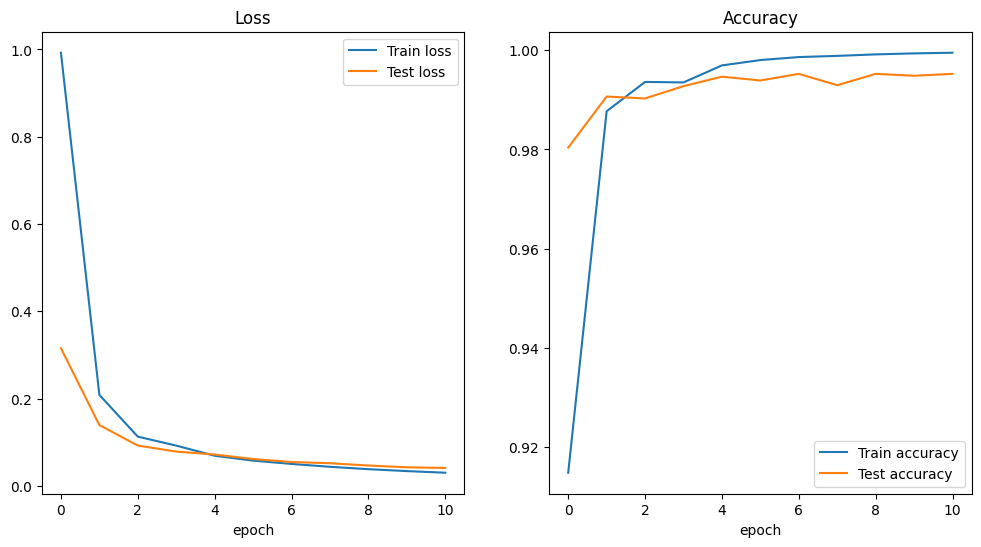

In [ ]:
name = "message_body"

with open("./models/LSTM_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

# LSTM_Glove

In [ ]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-04-28 07:01:45--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-28 07:01:46--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.04MB/s    in 2m 40s  

2023-04-28 07:04:27 (5.14 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
# 加载预训练词向量
def load_pretrained_embeddings(embedding_path, word_index, max_vocab, embedding_dim):
    embeddings_index = {}
    with open(embedding_path, encoding="utf-8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype="float32")
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((max_vocab, embedding_dim))
    for word, i in word_index.items():
        if i < max_vocab:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
def build_and_train_lstm_glove_model(x_train, y_train, x_val, y_val, embedding_matrix, name, batchsize=128):
    # 将 one-hot 编码的标签转换为二进制编码
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)
    
    # 计算类别权重
    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_matrix.shape[1], input_length=max_len, weights=[embedding_matrix], trainable=False))
    model.add(LSTM(units=embedding_matrix.shape[1] // 4))
    model.add(Dropout(0.6))
    model.add(Dense(1, activation='sigmoid'))
    
    # 使用自定义学习率
    custom_lr = 0.0005
    optimizer = Adam(learning_rate=custom_lr)
    
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/LSTM_model_" + name
    model.save(model_file)

    with open(f"./models/LSTM_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)


In [ ]:
# 读取 data
with open('data_06.pickle', 'rb') as handle:
    data = pickle.load(handle)
x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
# 加载预训练的GloVe词向量
embedding_path = "glove.6B.300d.txt"  
embedding_dim = 300  
embedding_matrix = load_pretrained_embeddings(embedding_path, tokenizer.word_index, max_vocab, embedding_dim)

In [ ]:
name = "message_glove"
batchsize=128
build_and_train_lstm_glove_model(x_train, y_train, x_test, y_test, embedding_matrix, name, batchsize)

Epoch 1/50
233/233 [==============================] - 31s 126ms/step - loss: 0.2245 - acc: 0.9153 - val_loss: 0.0934 - val_acc: 0.9745
Epoch 2/50
233/233 [==============================] - 28s 120ms/step - loss: 0.0920 - acc: 0.9749 - val_loss: 0.0716 - val_acc: 0.9794
Epoch 3/50
233/233 [==============================] - 28s 122ms/step - loss: 0.0723 - acc: 0.9807 - val_loss: 0.0674 - val_acc: 0.9827
Epoch 4/50
233/233 [==============================] - 28s 118ms/step - loss: 0.0861 - acc: 0.9761 - val_loss: 0.1662 - val_acc: 0.9613
Epoch 5/50
233/233 [==============================] - 33s 140ms/step - loss: 0.0633 - acc: 0.9824 - val_loss: 0.0488 - val_acc: 0.9855
Epoch 6/50
233/233 [==============================] - 28s 120ms/step - loss: 0.0546 - acc: 0.9856 - val_loss: 0.0637 - val_acc: 0.9823
Epoch 7/50
233/233 [==============================] - 28s 119ms/step - loss: 0.0475 - acc: 0.9878 - val_loss: 0.0545 - val_acc: 0.9846
Epoch 8/50
233/233 [==============================] - 3

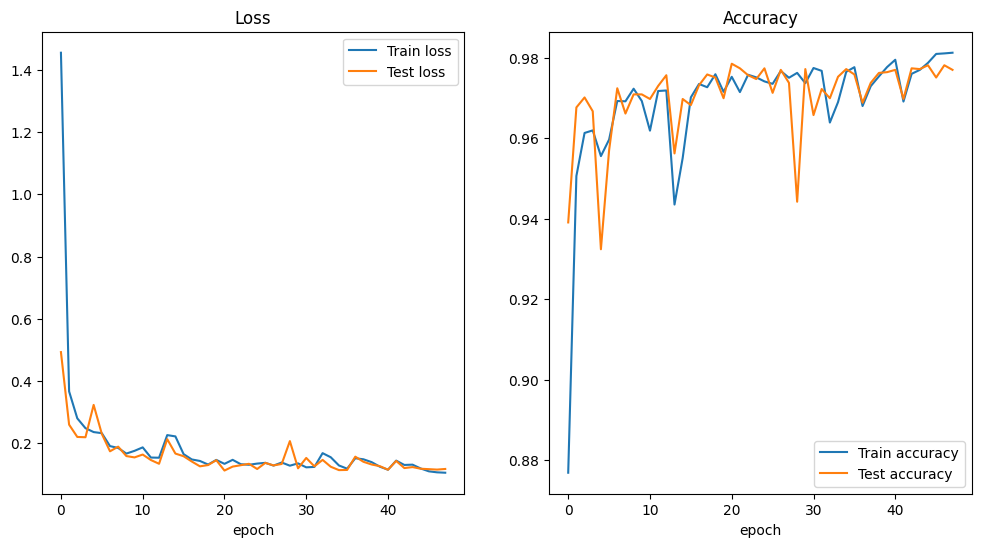

In [ ]:
name = "message_body_glove"

with open("./models/LSTM_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

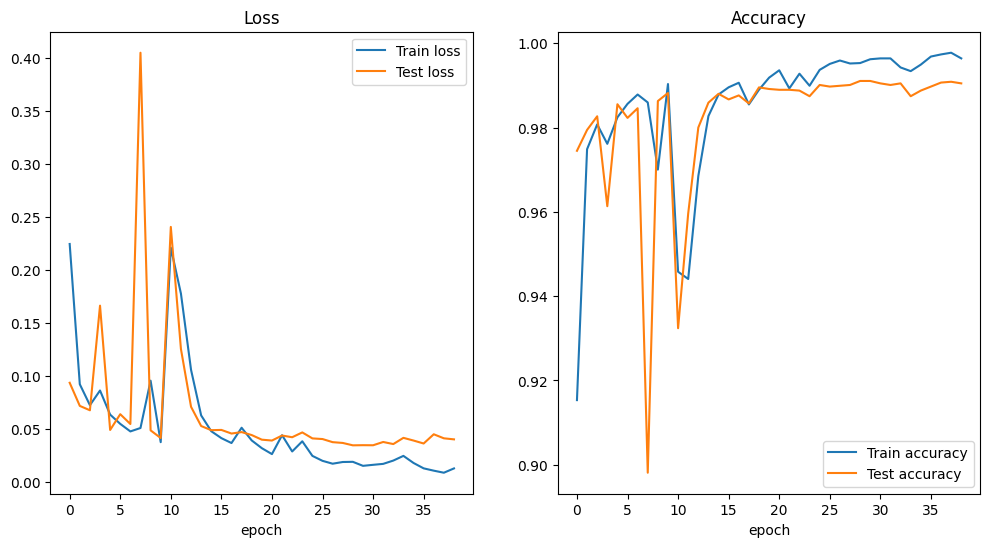

In [ ]:
name = "message_glove"

with open("./models/LSTM_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

name = "message_body_glove"

model_file = "./models/LSTM_model_" + name

# 从指定路径加载模型
model = load_model(model_file)

# 读取 data
with open('data_body_06.pickle', 'rb') as handle:
    data_body = pickle.load(handle)

x_train, x_test, y_train, y_test = split_data(data_body, labels)
y_pred = model.predict(x_test)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

165/165 [==============================] - 5s 26ms/step
Accuracy: 97.85%


In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

name = "message_glove"

model_file = "./models/LSTM_model_" + name

# 从指定路径加载模型
model = load_model(model_file)

# 读取 data
with open('data_06.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train, x_test, y_train, y_test = split_data(data, labels)
y_pred = model.predict(x_test)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))


165/165 [==============================] - 5s 26ms/step
Accuracy: 99.10%


# 1D-CNN

In [ ]:
def build_and_train_cnn_model(x_train, y_train, x_val, y_val, embedding_mat_columns, name, batchsize=128):
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)
    
    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)
    
    model = Sequential()
    model.add(Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/CNN_model_" + name
    model.save(model_file)

    with open(f"./models/CNN_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)


In [ ]:
x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
name = "message_body"
embedding_mat_columns = 128
batchsize = 128
build_and_train_cnn_model(x_train, y_train, x_test, y_test, embedding_mat_columns, name, batchsize)

Epoch 1/50
233/233 [==============================] - 71s 278ms/step - loss: 0.1267 - acc: 0.9637 - val_loss: 0.0181 - val_acc: 0.9939
Epoch 2/50
233/233 [==============================] - 59s 254ms/step - loss: 0.0064 - acc: 0.9983 - val_loss: 0.0149 - val_acc: 0.9939
Epoch 3/50
233/233 [==============================] - 54s 232ms/step - loss: 0.0011 - acc: 0.9997 - val_loss: 0.0148 - val_acc: 0.9937
Epoch 4/50
233/233 [==============================] - 50s 213ms/step - loss: 6.1723e-04 - acc: 0.9999 - val_loss: 0.0165 - val_acc: 0.9947
Epoch 5/50
233/233 [==============================] - 43s 185ms/step - loss: 6.9239e-04 - acc: 0.9999 - val_loss: 0.0158 - val_acc: 0.9947
Epoch 6/50
233/233 [==============================] - 43s 184ms/step - loss: 0.0010 - acc: 0.9999 - val_loss: 0.0161 - val_acc: 0.9949
Epoch 00006: early stopping


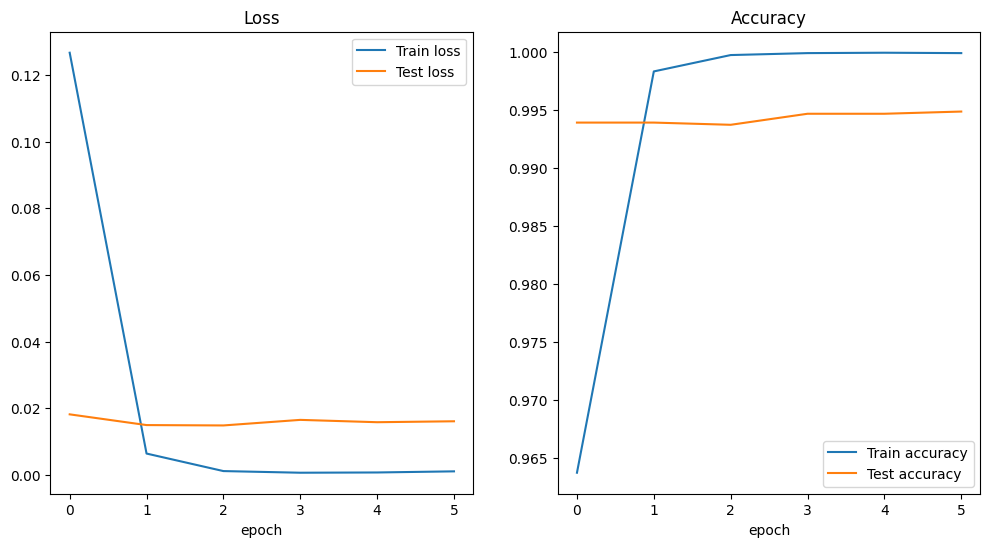

In [ ]:
name = "message_body"

with open("./models/CNN_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

# 1D-CNN_Glove

In [ ]:
def load_glove_embeddings(glove_file, word_index, embedding_dim):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix



In [ ]:
from tensorflow.keras.layers import Dropout

def build_and_train_cnn_glove_model(x_train, y_train, x_val, y_val, embedding_matrix, name, batchsize=128):
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)
    
    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)

    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Conv1D(64, 5, activation='relu'))
    model.add(MaxPooling1D(5))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, loss_threshold=0.01, restore_best_weights=True)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/CNN_model_" + name
    model.save(model_file)

    with open(f"./models/CNN_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)


In [ ]:
x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
glove_file = "glove.6B.300d.txt"  
embedding_dim = 300
embedding_matrix = load_glove_embeddings(glove_file, tokenizer.word_index, embedding_dim)
name = "message_body_glove"
batchsize=128
build_and_train_cnn_glove_model(x_train, y_train, x_test, y_test, embedding_matrix, name, batchsize)

Epoch 1/50
  6/233 [..............................] - ETA: 10s - loss: 0.6710 - acc: 0.4193

233/233 [==============================] - 26s 60ms/step - loss: 0.1985 - acc: 0.9183 - val_loss: 0.0679 - val_acc: 0.9819
Epoch 2/50
233/233 [==============================] - 13s 56ms/step - loss: 0.0578 - acc: 0.9849 - val_loss: 0.0490 - val_acc: 0.9872
Epoch 3/50
233/233 [==============================] - 13s 54ms/step - loss: 0.0371 - acc: 0.9915 - val_loss: 0.0471 - val_acc: 0.9869
Epoch 4/50
233/233 [==============================] - 13s 54ms/step - loss: 0.0255 - acc: 0.9951 - val_loss: 0.0460 - val_acc: 0.9901
Epoch 5/50
233/233 [==============================] - 13s 55ms/step - loss: 0.0199 - acc: 0.9963 - val_loss: 0.0476 - val_acc: 0.9901
Epoch 6/50
233/233 [==============================] - 13s 55ms/step - loss: 0.0178 - acc: 0.9967 - val_loss: 0.0597 - val_acc: 0.9882
Epoch 7/50
233/233 [==============================] - 13s 54ms/step - loss: 0.0201 - acc: 0.9960 - val_loss: 0.0490 - val_acc: 0.9891
Epoch 8/50
233/233 [==============================] - 13s 54ms/step - los

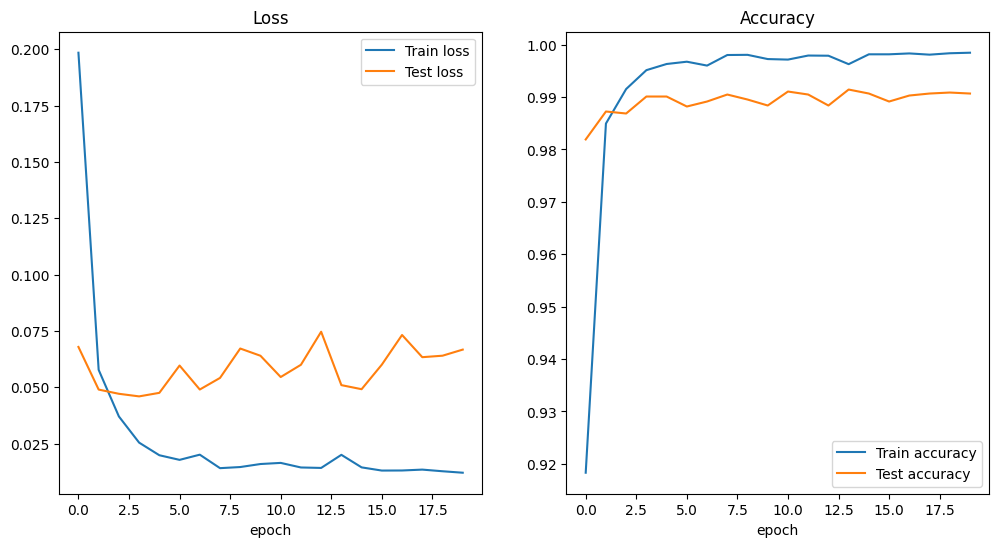

In [ ]:
name = "message_body_glove"

with open("./models/CNN_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

# 基于Transformer（内存不足）

In [ ]:
# def build_and_train_transformer_model(x_train, y_train, x_val, y_val, embedding_mat_columns, name, batchsize=128):
#     y_train_binary = np.argmax(y_train, axis=1)
#     y_val_binary = np.argmax(y_val, axis=1)
    
#     sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)

#     inputs = Input(shape=(max_len,))
#     x = Embedding(input_dim=max_vocab, output_dim=embedding_mat_columns, input_length=max_len)(inputs)
#     x = MultiHeadAttention(num_heads=8, key_dim=embedding_mat_columns)(x, x, x)
#     x = GlobalAveragePooling1D()(x)
#     x = Dense(64, activation='relu')(x)
#     outputs = Dense(1, activation='sigmoid')(x)

#     model = Model(inputs=inputs, outputs=outputs)

#     optimizer = Adam(learning_rate=0.001)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

#     early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
#     result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

#     model_file = "./models/Transformer_model_" + name
#     model.save(model_file)

#     with open(f"./models/Transformer_result_{name}.p", "wb") as f:
#         pickle.dump(result.history, f)


In [ ]:
# x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
# name = "message_body"
# embedding_mat_columns = 128
# batchsize = 128
# build_and_train_transformer_model(x_train, y_train, x_test, y_test, embedding_mat_columns, name, batchsize)


# 基于Transformer_Glove


In [ ]:
def load_glove_embeddings(glove_file, word_index, embedding_dim):
    embeddings_index = {}
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    return embedding_matrix

In [ ]:
glove_file = "glove.6B.100d.txt"  
embedding_dim = 100
embedding_matrix = load_glove_embeddings(glove_file, tokenizer.word_index, embedding_dim)

In [ ]:
def build_and_train_transformer_glove_model(x_train, y_train, x_val, y_val, embedding_matrix, name, batchsize=32):
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)

    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)

    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
    attention_layer = MultiHeadAttention(num_heads=4, key_dim=embedding_dim // 4, dropout=0.1)(embedding_layer, embedding_layer)
    pooling_layer = GlobalAveragePooling1D()(attention_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, loss_threshold=0.01, restore_best_weights=True)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/Transformer_model_" + name
    model.save(model_file)

    with open(f"./models/Transformer_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)

name = "message_glove"
batchsize = 32
x_train, x_test, y_train, y_test = split_data(data, labels)
build_and_train_transformer_glove_model(x_train, y_train, x_test, y_test, embedding_matrix, name, batchsize)


Epoch 1/50
  6/930 [..............................] - ETA: 1:21 - loss: 0.6814 - acc: 0.6146

930/930 [==============================] - 89s 91ms/step - loss: 0.2476 - acc: 0.9159 - val_loss: 0.1312 - val_acc: 0.9566
Epoch 2/50
930/930 [==============================] - 84s 90ms/step - loss: 0.1322 - acc: 0.9596 - val_loss: 0.1039 - val_acc: 0.9667
Epoch 3/50
930/930 [==============================] - 85s 91ms/step - loss: 0.1048 - acc: 0.9678 - val_loss: 0.1088 - val_acc: 0.9686
Epoch 4/50
930/930 [==============================] - 86s 92ms/step - loss: 0.0912 - acc: 0.9721 - val_loss: 0.1189 - val_acc: 0.9653
Epoch 5/50
930/930 [==============================] - 85s 91ms/step - loss: 0.0815 - acc: 0.9751 - val_loss: 0.1119 - val_acc: 0.9680
Epoch 6/50
930/930 [==============================] - 85s 91ms/step - loss: 0.0768 - acc: 0.9769 - val_loss: 0.0981 - val_acc: 0.9749
Epoch 7/50
930/930 [==============================] - 86s 92ms/step - loss: 0.0723 - acc: 0.9778 - val_loss: 0.0785 - val_acc: 0.9779
Epoch 8/50
930/930 [==============================] - 86s 92ms/step - los

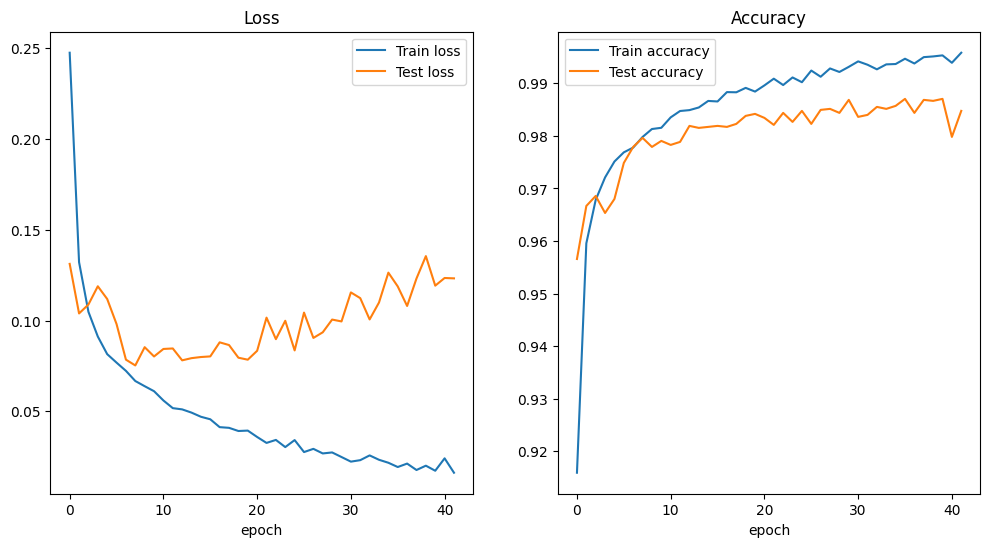

In [ ]:
name = "message_glove"

with open("./models/Transformer_result_{}.p".format(name),"rb") as f:
    result=pickle.load(f)


history=result
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.plot(history["loss"],label="Train loss")
plt.plot(history["val_loss"],label="Test loss")
plt.title('Loss')
plt.xlabel('epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["acc"],label="Train accuracy")
plt.plot(history["val_acc"],label="Test accuracy")
plt.title('Accuracy')
plt.xlabel('epoch')
plt.legend()

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

name = "message_glove"

model_file = "./models/Transformer_model_" + name

# 从指定路径加载模型
model = load_model(model_file)

# 读取 data
with open('data_06_max_len=1000.pickle', 'rb') as handle:
    data = pickle.load(handle)

x_train, x_test, y_train, y_test = split_data(data, labels)
y_pred = model.predict(x_test)
y_pred = np.round(np.squeeze(y_pred)).astype(int)
y_true = np.argmax(y_test, axis=1)
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy: %.2f%%" % (accuracy*100))

165/165 [==============================] - 7s 24ms/step
Accuracy: 98.44%


## 内存不足

In [ ]:
def build_and_train_transformer_glove_model(x_train, y_train, x_val, y_val, embedding_matrix, name, batchsize=128):
    y_train_binary = np.argmax(y_train, axis=1)
    y_val_binary = np.argmax(y_val, axis=1)

    sample_weights = class_weight.compute_sample_weight('balanced', y_train_binary)

    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=False)(input_layer)
    attention_layer = MultiHeadAttention(num_heads=8, key_dim=embedding_dim // 8, dropout=0.1)(embedding_layer, embedding_layer)
    pooling_layer = GlobalAveragePooling1D()(attention_layer)
    dropout_layer = Dropout(0.5)(pooling_layer)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, loss_threshold=0.01, restore_best_weights=True)
    result = model.fit(x_train, y_train_binary, epochs=50, batch_size=batchsize, validation_data=(x_val, y_val_binary), callbacks=[early_stopping], sample_weight=sample_weights)

    model_file = "./models/Transformer_model_" + name
    model.save(model_file)

    with open(f"./models/Transformer_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)


In [ ]:
x_train, x_test, y_train, y_test = split_data(data, labels)

In [ ]:
name = "message_body_glove"
batchsize=64
build_and_train_transformer_glove_model(x_train, y_train, x_test, y_test, embedding_matrix, name, batchsize)

Epoch 1/50


ResourceExhaustedError: ignored

# LSTM_BERT（内存不足）

In [ ]:
# print(x_train)
# print(y_train)
# print(x_test)
# print(y_test)

[[   0    0    0 ...   84 1541 7669]
 [   0    0    0 ... 1803 1184 1870]
 [   0    0    0 ...  456  110 1220]
 ...
 [   0    0    0 ... 2377 1569 2310]
 [   0    0    0 ...  153   85 1497]
 [   0    0    0 ... 9718   67   47]]
[[0 1]
 [0 1]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]
[[     0      0      0 ...  17772   2252   1953]
 [     0      0      0 ...  82803  82804  82805]
 [     0      0      0 ...  10282    712   4627]
 ...
 [     0      0      0 ...   8332   8333   8334]
 [     0      0      0 ...  28321  26113  28322]
 [     0      0      0 ...  27611  66005 157341]]
[[0 1]
 [0 1]
 [0 1]
 ...
 [0 1]
 [1 0]
 [1 0]]


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 35.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.8 MB/s eta 0:00:00


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_bert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=32):
    max_len = 128  # 根据您的实际情况调整此值

    # 使用预训练的 BERT 分词器对输入进行编码
    tokenizer = BertTokenizer.from_pretrained(model_name)
    x_train_encoded = tokenizer(x_train_raw, padding=True, truncation=True, max_length=max_len, return_tensors="tf")
    x_test_encoded = tokenizer(x_test_raw, padding=True, truncation=True, max_length=max_len, return_tensors="tf")

    # 构建分类器
    bert_model = TFBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    bert_output = bert_model(input_layer)
    pooled_output = bert_output.pooler_output  # 获取 BERT 模型的池化输出
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    # 创建和编译模型
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    # 训练模型
    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(x_train_encoded['input_ids'], y_train, epochs=50, batch_size=batchsize, validation_data=(x_test_encoded['input_ids'], y_test), callbacks=[early_stopping])

    model_file = "./models/BERT_model_" + name
    model.save(model_file)

    with open(f"./models/BERT_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)

# 使用原始文本数据拆分训练集和测试集
X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用预训练的 BERT 模型
model_name = "bert-base-uncased"
name = "message_body_bert"
batchsize = 32
build_and_train_bert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_bert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=16):
    max_len = 32  # 根据您的实际情况调整此值

    # 使用预训练的 BERT 分词器对输入进行编码
    tokenizer = BertTokenizer.from_pretrained(model_name)

    # 使用 tf.data.Dataset 进行数据流式传输
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    # 构建分类器
    bert_model = TFBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    bert_output = bert_model(input_layer)
    pooled_output = bert_output.pooler_output  # 获取 BERT 模型的池化输出
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    # 创建和编译模型
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    # 训练模型
    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    model_file = "./models/BERT_model_" + name
    model.save(model_file)

    with open(f"./models/BERT_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)

# 使用原始文本数据拆分训练集和测试集
X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

# 使用较小的预训练 BERT 模型
model_name = "distilbert-base-uncased"
name = "message_body_distilbert"
batchsize = 16
build_and_train_bert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

strategy = tf.distribute.OneDeviceStrategy("GPU:0")

def build_and_train_bert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=8):
    max_len = 32

    tokenizer = DistilBertTokenizer.from_pretrained(model_name)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    bert_model = TFDistilBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    bert_output = bert_model(input_layer)
    pooled_output = bert_output.pooler_output
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    model_file = "./models/DistilBERT_model_" + name
    model.save(model_file)

    with open(f"./models/DistilBERT_result_{name}.p", "wb") as f:
        pickle.dump(result.history, f)

X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

model_name = "distilbert-base-uncased"
name = "message_body_distilbert"
batchsize = 8

with strategy.scope():
    build_and_train_bert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import ElectraTokenizer, TFElectraModel
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

strategy = tf.distribute.OneDeviceStrategy("GPU:0")

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

def build_and_train_electra_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=4):
    max_len = 32

    tokenizer = ElectraTokenizer.from_pretrained(model_name)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    electra_model = TFElectraModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    electra_output = electra_model(input_layer)
    pooled_output = electra_output.pooler_output
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid', dtype=tf.float32)(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    return model

X = np.array(messages)
y = np.argmax(labels, axis=1)

model_name = "google/electra-small-discriminator"
name = "message_body_electra"
batchsize = 4

kf = KFold(n_splits=5) # Adjust the number of splits based on available GPU memory
i = 1
for train_index, test_index in kf.split(X):
    x_train_raw, x_test_raw = X[train_index], X[test_index]
    y_train_binary, y_test_binary = y[train_index], y[test_index]

    with strategy.scope():
        model = build_and_train_electra_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)

    model_file = f"./models/Electra_model_{name}_fold_{i}.h5"
    model.save(model_file)
    i += 1



In [ ]:
import numpy as np
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

strategy = tf.distribute.OneDeviceStrategy("GPU:0")

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

def build_and_train_distilbert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=4):
    max_len = 32

    tokenizer = DistilBertTokenizer.from_pretrained(model_name)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    distilbert_model = TFDistilBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    distilbert_output = distilbert_model(input_layer)
    pooled_output = distilbert_output.last_hidden_state[:, 0]
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid', dtype=tf.float32)(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    return model

X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

model_name = "distilbert-base-uncased"
name = "message_body_distilbert"
batchsize = 4

with strategy.scope():
    model = build_and_train_distilbert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)

model_file = f"./models/DistilBert_model_{name}.h5"
model.save(model_file)


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import mixed_precision

strategy = tf.distribute.OneDeviceStrategy("GPU:0")

policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

def build_and_train_tinybert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=4):
    max_len = 32

    tokenizer = BertTokenizer.from_pretrained(model_name)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    tinybert_model = TFBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    tinybert_output = tinybert_model(input_layer)
    pooled_output = tinybert_output.pooler_output
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid', dtype=tf.float32)(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    return model

X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

model_name = "prajjwal1/tinybert"
name = "message_body_tinybert"
batchsize = 4

with strategy.scope():
    model = build_and_train_tinybert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)

model_file = f"./models/TinyBert_model_{name}.h5"
model.save(model_file)


In [ ]:
import numpy as np
import tensorflow as tf
from transformers import MobileBertTokenizer, TFMobileBertModel
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_and_train_mobilebert_classifier(x_train_raw, y_train, x_test_raw, y_test, model_name, batchsize=4):
    max_len = 32

    tokenizer = MobileBertTokenizer.from_pretrained(model_name)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train_raw, y_train)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test_raw, y_test)).map(lambda x, y: (tokenizer(x, padding=True, truncation=True, max_length=max_len, return_tensors="tf"), y)).batch(batchsize)

    mobilebert_model = TFMobileBertModel.from_pretrained(model_name)
    input_layer = Input(shape=(max_len,), dtype=tf.int32)
    mobilebert_output = mobilebert_model(input_layer)
    pooled_output = mobilebert_output.pooler_output
    dropout_layer = Dropout(0.1)(pooled_output)
    output_layer = Dense(1, activation='sigmoid')(dropout_layer)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=2e-5), loss='binary_crossentropy', metrics=['acc'])

    early_stopping = CustomEarlyStopping(monitor='val_loss', patience=10, min_delta=0, mode='min', baseline=None, restore_best_weights=True, verbose=2, loss_threshold=0.01)
    result = model.fit(train_dataset, epochs=50, validation_data=test_dataset, callbacks=[early_stopping])

    return model

X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)

model_name = "google/mobilebert-uncased"
name = "message_body_mobilebert"
batchsize = 4

with strategy.scope():
    model = build_and_train_mobilebert_classifier(x_train_raw, y_train_binary, x_test_raw, y_test_binary, model_name, batchsize)

model_file = f"./models/MobileBert_model_{name}.h5"
model.save(model_file)


In [ ]:
import tensorflow as tf
from transformers import MobileBertTokenizer, TFAutoModel

def train_step(inputs, labels, model, optimizer, loss_object):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

def train_model(x_train, y_train, x_test, y_test, model_name, batch_size=4, epochs=1, max_len=32):
    tokenizer = MobileBertTokenizer.from_pretrained(model_name)
    model = TFAutoModel.from_pretrained(model_name)

    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(batch_size)
    test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(batch_size)

    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}/{epochs}")

        # Training
        batch = 0
        for inputs, labels in train_dataset:
            tokenized_inputs = tokenizer(list(inputs.numpy()), padding=True, truncation=True, max_length=max_len, return_tensors="tf")
            loss = train_step(tokenized_inputs, labels, model, optimizer, loss_object)
            if batch % 10 == 0:
                print(f"Batch: {batch}, Loss: {loss.numpy()}")
            batch += 1

        # Evaluation
        test_loss = 0
        test_batches = 0
        for inputs, labels in test_dataset:
            tokenized_inputs = tokenizer(list(inputs.numpy()), padding=True, truncation=True, max_length=max_len, return_tensors="tf")
            predictions = model(tokenized_inputs, training=False)
            loss = loss_object(labels, predictions)
            test_loss += loss
            test_batches += 1
        print(f"Test Loss: {test_loss/test_batches}")
        
X = np.array(messages)
y = np.argmax(labels, axis=1)
x_train_raw, x_test_raw, y_train_binary, y_test_binary = train_test_split(X, y, test_size=0.3, random_state=42)
train_model(x_train_raw, y_train_binary, x_test_raw, y_test_binary, "google/mobilebert-uncased", batch_size=4, epochs=1, max_len=32)
